## BERT模型训练说明
模型基于BERT-chinse-base进行finetune
* 请在根目录下创建目标目录（若已创建，则跳过）
* 请将此notebook另存到上一步所创建的目录下
* 请初始化相关路径变量

In [1]:
! jupyter notebook --version

7.2.1


In [1]:
import torch
 
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

ModuleNotFoundError: No module named 'torch'

## 导入包

In [2]:
import os
os.environ['TRANSFORMERS_CACHE'] = 'My_Model'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import trange, notebook
from tqdm import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

print(f'torch version: {torch.__version__}\ntransformers version: {transformers.__version__}')

d:\ProgramData\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch version: 1.13.1+cu116
transformers version: 4.33.3


## 初始化模型

In [3]:
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

model_name = 'bert-base-chinese'
# 下面三个文件的路径为 bert-base-chinese 文件夹，根据自己的存储路径更换
# 下载地址 https://mirrors.aliyun.com/huggingface/models/bert-base-chinese/
config = BertConfig.from_pretrained('model/'+model_name, finetuning_task='binary')  # BERT 模型配置
tokenizer = BertTokenizer.from_pretrained('model/'+model_name)  # BERT 的分词器
model = BertForSequenceClassification.from_pretrained('model/'+model_name, num_labels=2)  # BERT 的文本分类模型
 
# 用于将文本转换为BERT模型的输入标记
def get_tokens(text, tokenizer, max_seq_length, add_special_tokens=True): 
    # 使用分词器将文本转换为模型可以接受的输入格式
    input_ids = tokenizer.encode(text,
                                 add_special_tokens=add_special_tokens,
                                 truncation=True,
                                 max_length=max_seq_length,
                                 pad_to_max_length=True)
    # 创建一个关注掩码，标记哪些标记是真实文本标记
    attention_mask = [int(id > 0) for id in input_ids]
    # 确保输入标记和关注掩码的长度等于最大序列长度
    assert len(input_ids) == max_seq_length
    assert len(attention_mask) == max_seq_length
    return (input_ids, attention_mask)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at model/bert-base-chinese and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 导入标注数据

In [4]:


# 目标：保留话题的文字、移除poi超链接、视频超链接、保留表情图片中的标题文字、移除其他html标签
def prepare(text):
    import re
    # 删除包含 wbicon 的 <i> 标签以及它们之间的内容
    tokens = re.sub(re.compile(r'(<i\s+.*?wbicon.*?>.*?</i>)', re.S), '', text)
    # 删除与 HTML 匹配的标签，包括尖括号 < 和 > 之间的内容
    tokens = re.sub(re.compile(r'<(.*?)>', re.S), '', text)
    # 保留 <img title="xxx"> 中的 title 信息
    tokens = re.sub(re.compile(r'<img.*?(alt=["|\']{0,1}(.*?)["|\']{0,1}|title=["|\']{0,1}(.*?)["|\']{0,1})\s+.*?>', re.S|re.M), '\g<2>', text).strip()
    # 将匹配到的 <br/> 替换为 \n
    tokens = re.sub(re.compile(r'<br/>',re.S),'\n',text)
    # 移除文本内的连续重复内容
    # 移除连续发生3次及以上次数的重复性内容
    # 重复内容的字符串长度>=3
    tokens = re.sub(re.compile(r'([\s|\S]{2,}?)\1{2,}',re.S|re.M),'\g<1>',text)
    # 移除 poi链接、视频链接、直播链接
    urls=re.findall(r"<a.*?href=.*?<\/a>", text, re.I|re.S|re.M)
    url=[u for u in urls if '>2<' in u or 'location_default.png' in u or '视频</a>' in u or '视频</span></a>' in u or '直播</a>' in u]
    if len(url)>0:
        for u in url:
            tokens=text.replace(u,'')
            
    return tokens

# # 对content列进行清洗 由对应的地名在文本中去除content文本中的内容
# data['clean_content']=data.apply(lambda row: clean_content(row['content'],row['content_location_name']),axis=1)

# # 如果文本为空 去掉该行
# data=data[data['clean_content']!='']

# # 对清洗后的文本 进行 分词 放入jieba_cut列中
# data['jieba_cut']=data['clean_content'].apply(lambda x: jieba.lcut(x))

In [5]:
import psutil
from pandarallel import pandarallel

def clean_content(content):
    import re
    # 去除一些关键词
    content =content.replace('分享图片', '').replace('分享视频', '').replace('微博视频', '').replace('的微博视频', '').replace('网页链接','').replace('超话','').replace('br','')
    # 去除两个#和他们之间的文字
    content = re.sub(r'#.*#', '', content)
    # 去除@和他们之间的文字
    content = re.sub(r'@.*@', '', content)
    # 去除[]和他们之间的文字
    content = re.sub(r'\[.*?\]', '', content)
    # 保留表情符号，去除其他符号
    content = re.sub(r'[^\w\s\u4e00-\u9fa5\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0]', '', content)
    # 去除英文
    content = re.sub(r'[a-zA-Z]+', '', content)
    content = re.sub(r'\d+', '', content).replace(' ', '').replace('.', '').replace('_','')
    return content


pandarallel.initialize(nb_workers=psutil.cpu_count(logical=False))

df_label = pd.read_csv('data\WeiboTrainData\weibo_label.csv')

df_label['message'] = df_label['message'].parallel_apply(clean_content)

df_label.sentiment.value_counts()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


sentiment
 1    7597
 6    4945
 0    2768
-1     683
Name: count, dtype: int64

## 垃圾文本预测

In [6]:
df = df_label.copy()
df.loc[df[df.sentiment!=6].index,'sentiment'] = 1

df = df[(df['sentiment']==1)|(df['sentiment']==6)]
# 随机丢弃标注列表中量较多的数据，以保持二者的标注量基本相同，提高后期模型预测的准确率
drop_size = len(df[df['sentiment']==1].sentiment)-len(df[df['sentiment']==6].sentiment)
df.drop(df[df['sentiment']==1].sample(drop_size).index, inplace=True)

df.sentiment.unique()

array([6, 1], dtype=int64)

In [7]:
df.loc[df[df.sentiment==6].index,'sentiment'] = 0
df.sentiment.unique()

array([0, 1], dtype=int64)

In [8]:
df.sample(10)

,mid,message,sentiment
4261,4.820000e+15,星期五阴今天的午餐爆炒花甲红烧带鱼小白菜鸡蛋汤,1
15676,4.230000e+15,说不害怕是假的每时每刻心里都在难受疑神疑鬼两个性格太过相近的人真的很难太累了有一千零一种方式...,0
7070,4.230000e+15,分享一则小甜蜜我见哥哥的时候他和我打闹我对着他说没惹我哈我现在还有人追呢哥哥说哪个哪个追你我...,1
10415,4.230000e+15,有的时候啊我就很想爆粗口听个网易云点开评论劳资觉得好听还不能拿自己账号评论了评论就是混圈滚犊...,0
13995,4.230000e+15,整个人都无语了原来有那么人都是小公主还要等着哄吗恶心,0
15647,4.230000e+15,说了再也不看青春感伤剧还是不得已被拉了去看虽然男主是渣男但还是有点难受以后再也不要跟一个到感...,0
15448,4.230000e+15,真的觉得那种在微信上跟你说着什么事拖拖拉拉半天确定不下来一会消失一会出现的人是需要别人好好教...,0
14088,4.230000e+15,就不多说操作策略是什么了说了也把我的话当耳边风非要反着跟我去操作我都无语了每次我提示大家获利...,0
14039,4.230000e+15,哪位高人能指点一下对付那种欠钱不还的人该怎么办欠我万元钱明明自己手头有钱家里还是做生意的开着...,0
15447,4.230000e+15,我真的烦死某些人干的优越感了是是是你们平胸又矮裙子就都该做成超高腰款我们大胸不配穿裙子好吧不...,0


### 数据集划分

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(df['message'],  # 文本消息数据
                                                    df['sentiment'],  # 文本情感标签
                                                    test_size=0.2,    # 测试集占总数据的比例
                                                    random_state=42,  # 随机种子，以确保可重复性
                                                    stratify=df['sentiment'])  # 根据情感标签进行分层抽样
# 使用自定义函数 get_tokens 对训练集和测试集的文本进行分词，每个文本最多包含150个标记
X_train_tokens = X_train.apply(get_tokens, args=(tokenizer, 150))
X_test_tokens = X_test.apply(get_tokens, args=(tokenizer, 150))

### 训练准备

In [10]:
# 将训练集的文本特征转换为PyTorch张量
input_ids_train = torch.tensor(
    [features[0] for features in X_train_tokens.values], dtype=torch.long)  # 输入特征 ID
input_mask_train = torch.tensor(
    [features[1] for features in X_train_tokens.values], dtype=torch.long)  # 输入掩码
label_ids_train = torch.tensor(Y_train.values, dtype=torch.long)  # 标签 ID

# # 输出训练集张量的形状
# print(input_ids_train.shape)  # 输出训练集输入特征的形状
# print(input_mask_train.shape)  # 输出训练集输入掩码的形状
# print(label_ids_train.shape)  # 输出训练集标签的形状

# 创建训练数据集
train_dataset = TensorDataset(input_ids_train, input_mask_train, label_ids_train)

# 将测试集的文本特征转换为PyTorch张量
input_ids_test = torch.tensor([features[0] for features in X_test_tokens.values], dtype=torch.long)
input_mask_test = torch.tensor([features[1] for features in X_test_tokens.values], dtype=torch.long)
label_ids_test = torch.tensor(Y_test.values, dtype=torch.long)

# 创建测试数据集
test_dataset = TensorDataset(input_ids_test, input_mask_test, label_ids_test)

In [28]:
# 训练批次大小和训练周期数
# train_batch_size = 64
train_batch_size = 16
num_train_epochs = 3

# 创建训练数据采样器和数据加载器
train_sampler = RandomSampler(train_dataset)  # 随机采样器，用于随机选择训练样本
train_dataloader = DataLoader(train_dataset, 
                              sampler=train_sampler, 
                              batch_size=train_batch_size)  # 创建训练数据加载器
t_total = len(train_dataloader) // num_train_epochs  # 计算总的训练步数

# 输出一些训练相关的信息
print("样本数量 =", len(train_dataset))  # 输出训练集样本数量
print("训练周期数 =", num_train_epochs)  # 输出训练周期数
print("总的训练批次大小 =", train_batch_size)  # 输出总的训练批次大小
print("总的优化步数 =", t_total)  # 输出总的优化步数

# 优化器和学习率调度器的设置
learning_rate = 5e-5  # 学习率
adam_epsilon = 1e-8  # Adam优化器的epsilon值
warmup_steps = 0  # 学习率预热步数

# 创建AdamW优化器和学习率调度器
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=t_total)  # 创建学习率调度器

样本数量 = 7912
训练周期数 = 3
总的训练批次大小 = 64
总的优化步数 = 41


In [ ]:
import torch
from torch.utils.data import RandomSampler, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import trange, tqdm
from torch.cuda.amp import autocast, GradScaler

# 假设 train_dataset 已经定义
# train_dataset = ...

# 检测是否有GPU可用，如果有则使用GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练批次大小和训练周期数
train_batch_size = 32  # 进一步减小批次大小
num_train_epochs = 3

# 创建训练数据采样器和数据加载器
train_sampler = RandomSampler(train_dataset)  # 随机采样器，用于随机选择训练样本
train_dataloader = DataLoader(train_dataset, 
                              sampler=train_sampler, 
                              batch_size=train_batch_size)  # 创建训练数据加载器

# 计算总的优化步数
gradient_accumulation_steps = 8  # 增加梯度累积步数
t_total = len(train_dataloader) // (num_train_epochs * gradient_accumulation_steps)

# 优化器和学习率调度器的设置
learning_rate = 5e-5  # 学习率
adam_epsilon = 1e-8  # Adam优化器的epsilon值
warmup_steps = 0  # 学习率预热步数

# 创建AdamW优化器和学习率调度器
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=t_total)  # 创建学习率调度器

# 混合精度训练
scaler = GradScaler()

# 创建一个描述训练周期的迭代器
train_iterator = trange(num_train_epochs, desc="Epoch")

# 将模型置于 train 模式
model.train()

for epoch in train_iterator:
    # 创建一个描述迭代的迭代器
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
        # 重置每个迭代开始时的所有梯度
        model.zero_grad()
        
        # 将模型和输入数据移到GPU（如果可用）
        model.to(device)  # 将模型移到GPU或CPU
        cuda = next(model.parameters()).device
        batch = tuple(t.to(cuda) for t in batch)  # 将批次数据移到GPU或CPU

        # 确定传递给模型的输入
        inputs = {
            'input_ids': batch[0],      # 输入特征ID
            'attention_mask': batch[1], # 输入掩码
            'labels': batch[2]         # 标签
        }

        # 通过模型进行前向传播：输入 -> 模型 -> 输出
        with autocast():
            outputs = model(**inputs)
            loss = outputs[0]
            loss = loss / gradient_accumulation_steps
        
        # 反向传播损失，自动计算梯度
        scaler.scale(loss).backward()

        # 通过将梯度限制在一定范围内来防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 更新模型参数和学习率
        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        # 打印当前损失值
        print("\r%f" % loss, end='')


### 训练

In [ ]:
# 检测是否有GPU可用，如果有则使用GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建一个描述训练周期的迭代器
train_iterator = trange(num_train_epochs, desc="Epoch")

# 将模型置于 train 模式
model.train()

for epoch in train_iterator:
    # 创建一个描述迭代的迭代器
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
        # 重置每个迭代开始时的所有梯度
        model.zero_grad()
        
        # 将模型和输入数据移到GPU（如果可用）
        # torch.cuda.empty_cache()  # 清理GPU缓存
        model.to(device)  # 将模型移到GPU或CPU
        cuda = next(model.parameters()).device
        batch = tuple(t.to(cuda) for t in batch)  # 将批次数据移到GPU或CPU

        # 确定传递给模型的输入
        inputs = {
            'input_ids': batch[0],      # 输入特征ID
            'attention_mask': batch[1], # 输入掩码
            'labels': batch[2]         # 标签
        }

        # 通过模型进行前向传播：输入 -> 模型 -> 输出
        outputs = model(**inputs)

        # 计算损失
        loss = outputs[0]

        # 打印当前损失值
        print("\r%f" % loss, end='')

        # 反向传播损失，自动计算梯度
        loss.backward()

        # 通过将梯度限制在一定范围内来防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 更新模型参数和学习率
        optimizer.step()
        scheduler.step()

保存模型

In [14]:
model.save_pretrained('My_Model/weibo-bert-rubbish-model')

### 验证模型并评估精度

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 测试批次大小
test_batch_size = 64

# 创建测试数据采样器和数据加载器
test_sampler = SequentialSampler(test_dataset)  # 顺序采样器，用于顺序选择测试样本
test_dataloader = DataLoader(test_dataset, 
                             sampler=test_sampler, 
                             batch_size=test_batch_size)  # 创建测试数据加载器

# 加载之前保存的预训练模型
# model = model.from_pretrained('/outputs')

# 初始化预测和实际标签
preds = None
out_label_ids = None

# 将模型置于 eval 模式
model.eval()

for batch in tqdm(test_dataloader, desc="评估中"):
    # 将模型和输入数据移到GPU（如果可用）
    model.to(device)
    batch = tuple(t.to(device) for t in batch)
    
    # 在 eval 模式下不跟踪任何梯度
    with torch.no_grad():
        inputs = {
            'input_ids': batch[0],  # 输入特征ID
            'attention_mask': batch[1],  # 输入掩码
            'labels': batch[2]  # 标签
        }        

        # 通过模型进行前向传播
        outputs = model(**inputs)

        # 我们得到损失，因为我们提供了标签
        tmp_eval_loss, logits = outputs[:2]

        # 测试数据集可能包含多个批次的项目
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, 
                                      inputs['labels'].detach().cpu().numpy(), 
                                      axis=0)

# 计算最终损失、预测和准确度
preds = np.argmax(preds, axis=1)  # 获取预测类别
acc_score = accuracy_score(preds, out_label_ids)  # 计算准确度
f1_score = f1_score(preds, out_label_ids)  # 计算F1分数
print ('测试集中的Accuracy分数: ', acc_score)
print ('测试集中的F1分数: ', f1_score)

### 预测

In [ ]:
import pandas as pd
import numpy as np

df_origin = pd.read_csv('D:/Code/Python/社交媒体情感/上海2019_2023年按月分类文件/20191201_20200101 57356 条.csv')
df_origin['label'] = 0 #统一初始化为0
# 对文本进行清洗
df_origin['text'] = df_origin.content.str.replace('\n',' ')

# def clean_content(content,place):
#     # 删除地名
#     content = content.replace(place,'')
#     # 删除特殊字符
#     content = content.replace('分享图片', '').replace('分享视频', '').replace('微博视频', '').replace('的微博视频', '').replace('#','').replace('，', ' ').replace(',','').replace('。', ' ').replace('；', ' ').replace('、', ' ').replace('！', ' ').replace('+', ' ').replace('：', ' ').replace('"', '').replace("'", '').replace('/', ' ').replace("|", ' ').replace('……', '').replace('=','').replace('-','').replace('&','').replace(':','').replace('%','').replace('?','')
#     # 去除数字和空格
#     content = re.sub(r'\d+', '', content).replace(' ', '').replace('.','')
#     # 去除一些符号
#     content = content.replace('_','').replace('','').replace('[', '').replace(']', '').replace('【','').replace('】','').replace('<','').replace('>','').replace('《','').replace('》','').replace('（','').replace('）','').replace('(','').replace(')','')
#     # 去掉两个#及中间的字符
#     # content = re.sub(r'#.*#', '', content)
#     # 把a到z的字母去掉
#     content = re.sub(r'[a-zA-Z]+', '', content)
#     # 只保留中文
#     # content = ''.join(filter(lambda x: '\u4e00' <= x <= '\u9fa5', content))
#     return content

def clean_content(content,place):
    import re
    # 去除地名
    content = content.replace(place, '')
    # 去除一些关键词
    content =content.replace('分享图片', '').replace('分享视频', '').replace('微博视频', '').replace('的微博视频', '').replace('网页链接','').replace('超话','').replace('br','')
    # 去除两个#和他们之间的文字
    content = re.sub(r'#.*#', '', content)
    # 去除@和他们之间的文字
    content = re.sub(r'@.*@', '', content)
    # 去除[]和他们之间的文字
    content = re.sub(r'\[.*?\]', '', content)
    # 保留表情符号，去除其他符号
    content = re.sub(r'[^\w\s\u4e00-\u9fa5\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0]', '', content)
    # 去除英文
    content = re.sub(r'[a-zA-Z]+', '', content)
    content = re.sub(r'\d+', '', content).replace(' ', '').replace('.', '').replace('_','')
    return content

# 对content列进行清洗 由对应的地名在文本中去除content文本中的内容
df_origin['text']=df_origin.apply(lambda row: clean_content(row['text'],row['content_location_name']),axis=1)

# 如果文本为空 去掉该行
df_origin=df_origin[df_origin['text']!='']

print(df_origin)

X_pred=df_origin['text']
Y_pred=df_origin['label']
X_pred_tokens = X_pred.parallel_apply(get_tokens, args=(tokenizer, 150))

input_ids_pred = torch.tensor(
    [features[0] for features in X_pred_tokens.values], dtype=torch.long)
input_mask_pred = torch.tensor(
    [features[1] for features in X_pred_tokens.values], dtype=torch.long)
label_pred=torch.tensor(Y_pred.values,dtype=torch.long)
pred_dataset = TensorDataset(input_ids_pred,input_mask_pred,label_pred)

pred_batch_size = 256
pred_sampler = SequentialSampler(pred_dataset)
pred_dataloader = DataLoader(pred_dataset, 
                             sampler=pred_sampler, 
                             batch_size=pred_batch_size)

# 调用训练好的模型
model = model.from_pretrained('My_Model/weibo-bert-rubbish-model')
preds = None
model.eval()

# 预测
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for batch in tqdm(pred_dataloader, desc="Predict"):
    
    batch = tuple(t.to(device) for t in batch)
    
    with torch.no_grad():
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        outputs = model(**inputs)
        _, logits = outputs[:2]

        if preds is None:
            preds = logits.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)

prob = torch.nn.functional.softmax(torch.tensor(preds), dim=1)  # 使用softmax函数计算预测的概率分布
preds = np.argmax(preds, axis=1)  # 计算每个样本的最终预测类别
df_origin['ad_prob'] = [p[1].item() for p in prob]  # 将概率分布的第二列（表示"1"类别的概率）添加到DataFrame中
df_origin['pred'] = preds  # 将最终的预测类别添加到DataFrame中

df_origin.sample(10)

### 预测

In [ ]:
df_origin = pd.read_csv('data/weibo_origin.csv')
df_origin['label'] = 0 #统一初始化为0
df_origin['text'] = df_origin.message.str.replace('\n',' ')
print(df_origin)


In [ ]:
X_pred=df_origin['text']
Y_pred=df_origin['label']
X_pred_tokens = X_pred.parallel_apply(get_tokens, args=(tokenizer, 150))

input_ids_pred = torch.tensor(
    [features[0] for features in X_pred_tokens.values], dtype=torch.long)
input_mask_pred = torch.tensor(
    [features[1] for features in X_pred_tokens.values], dtype=torch.long)
label_pred=torch.tensor(Y_pred.values,dtype=torch.long)
pred_dataset = TensorDataset(input_ids_pred,input_mask_pred,label_pred)

pred_batch_size = 256
pred_sampler = SequentialSampler(pred_dataset)
pred_dataloader = DataLoader(pred_dataset, 
                             sampler=pred_sampler, 
                             batch_size=pred_batch_size)

In [ ]:
# 调用训练好的模型
model = model.from_pretrained('My_Model/weibo-bert-rubbish-model')
preds = None
model.eval()

In [ ]:
# 预测
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for batch in tqdm(pred_dataloader, desc="Predict"):
    
    batch = tuple(t.to(device) for t in batch)
    
    with torch.no_grad():
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        outputs = model(**inputs)
        _, logits = outputs[:2]

        if preds is None:
            preds = logits.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)

In [ ]:
prob = torch.nn.functional.softmax(torch.tensor(preds), dim=1)  # 使用softmax函数计算预测的概率分布
preds = np.argmax(preds, axis=1)  # 计算每个样本的最终预测类别
df_origin['ad_prob'] = [p[1].item() for p in prob]  # 将概率分布的第二列（表示"1"类别的概率）添加到DataFrame中
df_origin['pred'] = preds  # 将最终的预测类别添加到DataFrame中

In [ ]:
df_origin.sample(10)

### BERT

转移时，转移My_Model 以及weibo_label.csv

In [ ]:
import re
import torch
import pandas as pd
import numpy as np
import psutil
from pandarallel import pandarallel
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import trange, tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

def clean_content(content):
    import re    
    # 去除一些关键词
    content =content.replace('分享图片', '').replace('分享视频', '').replace('微博视频', '').replace('的微博视频', '').replace('网页链接','').replace('超话','').replace('br','')
    # 去除两个#和他们之间的文字
    content = re.sub(r'#.*#', '', content)
    # 去除@和他们之间的文字
    content = re.sub(r'@.*@', '', content)
    # 去除[]和他们之间的文字
    content = re.sub(r'\[.*?\]', '', content)
    # 保留表情符号，去除其他符号
    content = re.sub(r'[^\w\s\u4e00-\u9fa5\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0]', '', content)
    # 去除英文
    content = re.sub(r'[a-zA-Z]+', '', content)
    content = re.sub(r'\d+', '', content).replace(' ', '').replace('.', '').replace('_','')
    return content

# 初始化pandarallel
pandarallel.initialize(nb_workers=psutil.cpu_count(logical=False))

# 读取数据
df_label = pd.read_csv('data\WeiboTrainData\weibo_label.csv')

# 清洗数据
df_label['message'] = df_label['message'].parallel_apply(clean_content)

# 去除空的行
df_label= df_label[df_label['message'] != '']

# 数据预处理
df_label.sentiment.value_counts()
df = df_label.copy()
df.loc[df[df.sentiment!=6].index,'sentiment'] = 1
df = df[(df['sentiment']==1) | (df['sentiment']==6)]
drop_size = len(df[df['sentiment']==1].sentiment) - len(df[df['sentiment']==6].sentiment)
df.drop(df[df['sentiment']==1].sample(drop_size).index, inplace=True)
df.loc[df[df.sentiment==6].index,'sentiment'] = 0
print(df.sentiment.unique())
print(df)

# 划分训练集和测试集
# X_train, X_test, Y_train, Y_test = train_test_split(df['message'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])
X_train, X_test, Y_train, Y_test = train_test_split(df['message'], df['sentiment'], test_size=0.7, random_state=42, stratify=df['sentiment'])

# 加载BERT模型和分词器
model_name = 'bert-base-chinese'
config = BertConfig.from_pretrained('model/' + model_name)
tokenizer = BertTokenizer.from_pretrained('model/' + model_name)
model = BertForSequenceClassification.from_pretrained('model/' + model_name, num_labels=2)

# 定义分词函数
def get_tokens(text, tokenizer, max_seq_length, add_special_tokens=True):
    input_ids = tokenizer.encode(text, add_special_tokens=add_special_tokens, truncation=True, max_length=max_seq_length, pad_to_max_length=True)
    attention_mask = [int(id > 0) for id in input_ids]
    assert len(input_ids) == max_seq_length
    assert len(attention_mask) == max_seq_length
    return (input_ids, attention_mask)

# 对训练集和测试集进行分词
X_train_tokens = X_train.apply(get_tokens, args=(tokenizer, 150))
X_test_tokens = X_test.apply(get_tokens, args=(tokenizer, 150))

# 转换为PyTorch张量
input_ids_train = torch.tensor([features[0] for features in X_train_tokens.values], dtype=torch.long)
input_mask_train = torch.tensor([features[1] for features in X_train_tokens.values], dtype=torch.long)
label_ids_train = torch.tensor(Y_train.values, dtype=torch.long)

input_ids_test = torch.tensor([features[0] for features in X_test_tokens.values], dtype=torch.long)
input_mask_test = torch.tensor([features[1] for features in X_test_tokens.values], dtype=torch.long)
label_ids_test = torch.tensor(Y_test.values, dtype=torch.long)

# 创建数据集
train_dataset = TensorDataset(input_ids_train, input_mask_train, label_ids_train)
test_dataset = TensorDataset(input_ids_test, input_mask_test, label_ids_test)

# 训练参数
train_batch_size = 64
num_train_epochs = 3
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=train_batch_size)
t_total = len(train_dataloader) // num_train_epochs

# 输出一些训练相关的信息
print("样本数量 =", len(train_dataset))  # 输出训练集样本数量
print("训练周期数 =", num_train_epochs)  # 输出训练周期数
print("总的训练批次大小 =", train_batch_size)  # 输出总的训练批次大小
print("总的优化步数 =", t_total)  # 输出总的优化步数

# 优化器和学习率调度器
learning_rate = 5e-5
adam_epsilon = 1e-8
warmup_steps = 0
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

# 设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import csv

# 训练模型
model.train()
train_iterator = trange(num_train_epochs, desc="Epoch")
for epoch in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    # 创建csv文件并写入表头
    with open('loss.csv', 'a', newline='') as csvfile:
        fieldnames = ['epoch', 'step', 'loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        for step, batch in enumerate(epoch_iterator):
            model.zero_grad()
            model.to(device)
            cuda=next(model.parameters()).device
            batch = tuple(t.to(device) for t in batch)
            inputs = {
                'input_ids': batch[0], # 输入特征ID
                'attention_mask': batch[1],  # 输入掩码
                'labels': batch[2]} # 标签
            # 通过模型进行 前向传播：输入->模型->输出
            outputs = model(**inputs)
            # 计算损失
            loss = outputs[0]

        
            # 在循环内部保存epoch、step和loss到csv文件
            writer.writerow({'epoch': epoch, 'step': step, 'loss': loss.item()})


            # 打印损失值
            print("\r%f" % loss,end='')

            # 反响传播损失，自动计算梯度
            loss.backward()
        
            # 通过将梯度限制在一定范围内来防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # 更新模型参数和学习率
            optimizer.step()
            scheduler.step()


# 保存模型
model.save_pretrained('My_Model/weibo-bert-rubbish-model')

# 评估模型
test_batch_size = 64
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=test_batch_size)

model.eval()
preds = None
out_label_ids = None

for batch in tqdm(test_dataloader, desc="评估中"):
    model.to(device)
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)
        tmp_eval_loss, logits = outputs[:2]
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

preds = np.argmax(preds, axis=1)
acc_score = accuracy_score(preds, out_label_ids)
f1_score = f1_score(preds, out_label_ids)
print('测试集中的Accuracy分数: ', acc_score)
print('测试集中的F1分数: ', f1_score)


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from tqdm import tqdm

# 读取数据
# df_origin = pd.read_csv(r'D:/Code/Python/senetiment/data/上海2019_2023年按月分类文件/20191201_20200101 57356 条.csv')
df_origin = pd.read_csv(r'D:/Code/Python/社交媒体情感/data/上海2019_2023年按月分类文件/20200201_20200301 27808 条.csv')
# 只取三行数据
# df_origin = df_origin.head(100)
df_origin['label'] = 0  # 统一初始化为0

# 对文本进行清洗
df_origin['text'] = df_origin.content.str.replace('\n', ' ')

def clean_content(content,place):
    import re
    # 去除地名
    content = content.replace(place, '')
    # 去除一些关键词
    content =content.replace('分享图片', '').replace('分享视频', '').replace('微博视频', '').replace('的微博视频', '').replace('网页链接','').replace('超话','').replace('br','')
    # 去除两个#和他们之间的文字
    content = re.sub(r'#.*#', '', content)
    # 去除@和他们之间的文字
    content = re.sub(r'@.*@', '', content)
    # 去除[]和他们之间的文字
    content = re.sub(r'\[.*?\]', '', content)
    # 保留表情符号，去除其他符号
    content = re.sub(r'[^\w\s\u4e00-\u9fa5\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0]', '', content)
    # 去除英文
    content = re.sub(r'[a-zA-Z]+', '', content)
    content = re.sub(r'\d+', '', content).replace(' ', '').replace('.', '').replace('_','')
    return content

# 对content列进行清洗 由对应的地名在文本中去除content文本中的内容
df_origin['text'] = df_origin.apply(lambda row: clean_content(row['text'], row['content_location_name']), axis=1)

# 如果文本为空 去掉该行
df_origin = df_origin[df_origin['text'] != '']

print(df_origin)

X_pred = df_origin['text']
Y_pred = df_origin['label']

# 加载BERT模型和分词器
model_name = 'bert-base-chinese'
# tokenizer = BertTokenizer.from_pretrained('My_Model/weibo-bert-rubbish-model')
model = model.from_pretrained('My_Model/weibo-bert-rubbish-model')
# model = BertForSequenceClassification.from_pretrained('model/' + model_name)
# tokenizer = BertTokenizer.from_pretrained('model/' + model_name)

# 定义分词函数
def get_tokens(text, tokenizer, max_seq_length, add_special_tokens=True):
    input_ids = tokenizer.encode(text, add_special_tokens=add_special_tokens, truncation=True, max_length=max_seq_length, pad_to_max_length=True)
    attention_mask = [int(id > 0) for id in input_ids]
    assert len(input_ids) == max_seq_length
    assert len(attention_mask) == max_seq_length
    return (input_ids, attention_mask)

X_pred_tokens = X_pred.apply(get_tokens, args=(tokenizer, 150))

input_ids_pred = torch.tensor([features[0] for features in X_pred_tokens.values], dtype=torch.long)
input_mask_pred = torch.tensor([features[1] for features in X_pred_tokens.values], dtype=torch.long)
label_pred = torch.tensor(Y_pred.values, dtype=torch.long)
pred_dataset = TensorDataset(input_ids_pred, input_mask_pred, label_pred)

pred_batch_size = 256
pred_sampler = SequentialSampler(pred_dataset)
pred_dataloader = DataLoader(pred_dataset, sampler=pred_sampler, batch_size=pred_batch_size)

# 预测
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

preds = None
for batch in tqdm(pred_dataloader, desc="Predict"):
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        outputs = model(**inputs)
        _, logits = outputs[:2]

        if preds is None:
            preds = logits.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)

prob = torch.nn.functional.softmax(torch.tensor(preds), dim=1)  # 使用softmax函数计算预测的概率分布
preds = np.argmax(preds, axis=1)  # 计算每个样本的最终预测类别
df_origin['ad_prob'] = [p[1].item() for p in prob]  # 将概率分布的第二列（表示"1"类别的概率）添加到DataFrame中
df_origin['pred'] = preds  # 将最终的预测类别添加到DataFrame中

# print(df_origin.sample(10))
# df_origin


In [8]:
import datetime

df_origin.to_csv('data\WeiboTrainData\sentiment_analysis_data_{}_3.csv'.format(str(datetime.datetime.now()).split(' ')[0]), index=False,encoding='utf-8-sig')

In [9]:
print('测试集中的Accuracy分数: ', acc_score)
print('测试集中的F1分数: ', f1_score)

测试集中的Accuracy分数:  0.7201365187713311
测试集中的F1分数:  0.6870229007633589


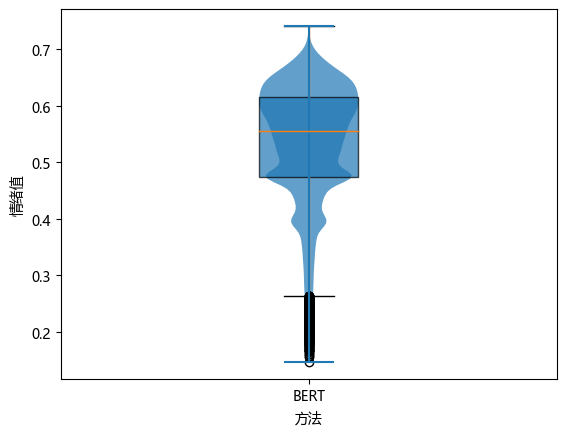

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fig, ax = plt.subplots()
box_positions = [0.5 - 0.1, 0.5+ 0.1]  # 调整位置，使两个箱线图并排显示
box_width = 0.2

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

# 绘制箱线图
box1 = ax.boxplot(df_origin['ad_prob'], widths=box_width, patch_artist=True,
                  boxprops=dict(facecolor='#1f77b4', alpha=0.7),
                  medianprops=dict(color='#ff7f0e'),  # 设置中位数线的颜色
                  whiskerprops=dict(color='#ff7f0e'))  # 设置须的颜色
# box2 = ax.boxplot(data['snownlp+emoji'], positions=[box_positions[1]], widths=box_width, patch_artist=True,
#                   boxprops=dict(facecolor='#ff7f0e', alpha=0.7),
#                   medianprops=dict(color='#1f77b4'),  # 设置中位数线的颜色
#                   whiskerprops=dict(color='#1f77b4'))  # 设置须的颜色

# 绘制琴谱图
violin1 = ax.violinplot(df_origin['ad_prob'], widths=box_width, showmedians=False)
# violin2 = ax.violinplot(data['snownlp+emoji'], positions=[box_positions[1]], widths=box_width, showmedians=False)

# 设置琴谱图的颜色和透明度
for violin, color in zip([violin1], ['#1f77b4', '#ff7f0e']):
    for pc in violin['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.7)

# 设置 x 轴标签
# ax.set_xticks([0.5])
ax.set_xticklabels(['BERT'])

# 设置标题和轴标签
# ax.set_title('SnowNLP加emoji')
ax.set_xlabel('方法')
ax.set_ylabel('情绪值')

plt.show()


In [2]:
import pandas as pd

data=pd.read_csv('data\WeiboTrainData\weibo_label.csv')
# 去掉data message列中只含有 分享图片的列
data=data[data['message']!='分享图片']
data.to_csv('data\WeiboTrainData\weibo_label.csv',index=False,encoding='utf-8-sig')
